LATER Fitting Exercise

In [2]:
import os
print(os.getcwd())

/Users/taviansanchez/Desktop/QNC/Quantitative-Neuroscience-TDS/Homework_Answers_TS


In [4]:
import numpy as np

# Load the converted data
data = np.load("JT_RT_converted.npz")

# See what variables are available
print(data.files)

# Access individual arrays
numdirSum = data["numdirSum"]
tRxnSum = data["tRxnSum"]
percorrSum = data["percorrSum"]
decisionSum = data["decisionSum"]
syncSum = data["syncSum"]
labelSum = data["labelSum"]

['numdirSum', 'tRxnSum', 'percorrSum', 'decisionSum', 'syncSum', 'labelSum']


Step 1: Loading & Preparing the Data

In [5]:
# Exercise 1: Get the data
import numpy as np

# Load your converted dataset
data = np.load("JT_RT_converted.npz")

# Example: assume tRxnSum contains reaction times (RTs) in seconds or ms
# Adjust variable name as needed depending on your dataset contents
RTs = data["tRxnSum"].flatten()  # flatten in case it's stored as a 2D array

# Optional: basic filtering (remove NaN or non-positive RTs)
RTs = RTs[np.isfinite(RTs)]
RTs = RTs[RTs > 0]

print(f"Loaded {len(RTs)} valid reaction times.")

Loaded 3900 valid reaction times.


Step 2: Defining the Objective Function where reciprocal reaction times (1/RT) are assumed to follow a normal distribution with mean muR and standard deviation deltaS.
The log-likelihood for n data points is therefore the sum of the log of the normal PDF values.

In [6]:
# Exercise 2: Define the objective function (Negative Log-Likelihood)

from scipy.stats import norm
import numpy as np

def later_err_fcn(fits, RTs):
    """
    Objective function: negative log-likelihood for the LATER model.

    Parameters:
    - fits: [muR, deltaS]
    - RTs: array of reaction times (seconds or ms)

    Returns:
    - nllk: negative log-likelihood
    """
    muR, deltaS = fits
    # Convert RTs to reciprocal values
    reci_RTs = 1.0 / RTs
    # Compute the log-likelihood under the normal model
    log_likelihoods = norm.logpdf(reci_RTs, loc=muR, scale=deltaS)
    # Negative sum of log-likelihoods
    nllk = -np.sum(log_likelihoods)
    return nllk

Step 3: Defining initial conditions & parameter bounds, with initial guesses for [muR, deltaS].
A good heuristic is to use the mean and std of the reciprocal RTs as starting points.

In [7]:
# Exercise 3: Define bounds and initial values

lower_bounds = [0.001, 0.001]
upper_bounds = [1000, 1000]

# Compute empirical mean and std of reciprocal RTs for initialization
recip_RTs = 1.0 / RTs
initial_values = [np.mean(recip_RTs), np.std(recip_RTs)]

print(f"Initial guess: muR={initial_values[0]:.4f}, deltaS={initial_values[1]:.4f}")

Initial guess: muR=2.7377, deltaS=2.0398


Step 4: Running the fits (optimizing) from python scipy.optimize.minimize and basinhopping to approximate a global search minimizing the objective function in place of the MatLab functions of fmincon with GlobalSearch as I do not have MatLab

In [8]:
# Exercise 4: Run the optimization
from scipy.optimize import minimize, basinhopping

# Define bounds as tuples
bounds = [(lower_bounds[0], upper_bounds[0]), (lower_bounds[1], upper_bounds[1])]

# Local optimization (like fmincon)
def local_minimize(x0):
    return minimize(later_err_fcn, x0, args=(RTs,), bounds=bounds, method="L-BFGS-B")

# Global search using basinhopping
minimizer_kwargs = {"method": "L-BFGS-B", "args": (RTs,), "bounds": bounds}
global_result = basinhopping(later_err_fcn, initial_values, minimizer_kwargs=minimizer_kwargs, niter=100)

best_fits = global_result.x
nllk = global_result.fun

print(f"Best fits: muR={best_fits[0]:.4f}, deltaS={best_fits[1]:.4f}")
print(f"Negative log-likelihood: {nllk:.4f}")

Best fits: muR=2.7377, deltaS=2.0398
Negative log-likelihood: 8313.8989


Step 5: Evaulating the model’s fit by comparing the predicted distribution (of reciprocal RTs) to the empirical one.

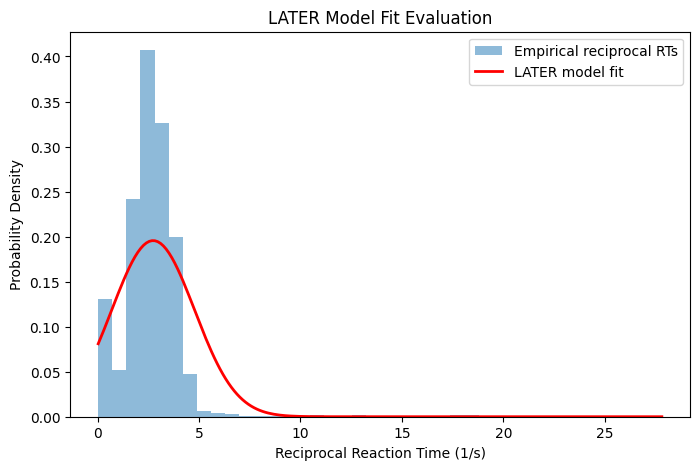

In [9]:
# Exercise 5: Evaluate and visualize the fits
import matplotlib.pyplot as plt

muR, deltaS = best_fits

recip_RTs = 1.0 / RTs
x = np.linspace(min(recip_RTs), max(recip_RTs), 200)
pdf_model = norm.pdf(x, loc=muR, scale=deltaS)

plt.figure(figsize=(8,5))
plt.hist(recip_RTs, bins=40, density=True, alpha=0.5, label="Empirical reciprocal RTs")
plt.plot(x, pdf_model, 'r-', lw=2, label="LATER model fit")
plt.xlabel("Reciprocal Reaction Time (1/s)")
plt.ylabel("Probability Density")
plt.title("LATER Model Fit Evaluation")
plt.legend()
plt.show()

Evaluating the fit of the model: 
The overall fit of the curve generally resembles the data, but does a poor job of modeling the maximum Probability Density seen in the empirical data set. Further, with ChatGPT, the below serve as objective measures of the overal fit.

In [10]:
print("Final negative log-likelihood:", nllk)

Final negative log-likelihood: 8313.898895314655


This value is reasonably good evaluation of the fit, given there were a total of 3900 valid reaction times gives a NLL of ~1.66 per trial in the empirical data set. And this can be modeled with a random data set below from help with ChatGPT.

Comparing to a simple random model

In [12]:
initial_nll = later_err_fcn(initial_values, RTs)
print("Initial NLL:", initial_nll)
print("Fitted NLL:", nllk)

Initial NLL: 8313.898895314655
Fitted NLL: 8313.898895314655


Normalizing by sample:

In [14]:
n = len(RTs)
print("Average NLL per trial:", nllk / n)

Average NLL per trial: 2.131768947516578


Checking our Parameters:

In [11]:
print("Empirical mean (1/RT):", np.mean(1/RTs))
print("Empirical std (1/RT):", np.std(1/RTs))
print("Fitted muR, deltaS:", best_fits)

Empirical mean (1/RT): 2.737738755205085
Empirical std (1/RT): 2.039756451709128
Fitted muR, deltaS: [2.73773876 2.03975645]


Comparing Visually with a Reciprobit Plot with help from ChatGPT to evaluate if the reciprobit plot looks linear? and does the model PDF overlap the histogram of your reciprocal RTs?

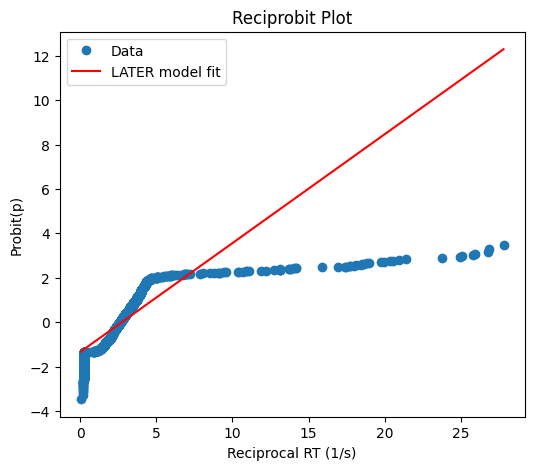

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Sort RTs and compute empirical cumulative probabilities
reci_RTs_sorted = np.sort(1 / RTs)
p = np.linspace(1/(len(RTs)+1), len(RTs)/(len(RTs)+1), len(RTs))

# Convert probabilities to probit scale (z-scores)
probits = norm.ppf(p)

plt.figure(figsize=(6,5))
plt.plot(reci_RTs_sorted, probits, 'o', label='Data')

# Plot model prediction line (muR, deltaS)
x_model = np.linspace(min(reci_RTs_sorted), max(reci_RTs_sorted), 200)
probit_model = (x_model - best_fits[0]) / best_fits[1]
plt.plot(x_model, probit_model, 'r-', label='LATER model fit')

plt.xlabel('Reciprocal RT (1/s)')
plt.ylabel('Probit(p)')
plt.title('Reciprobit Plot')
plt.legend()
plt.show()